# Time Series Classification using sktime
Time series classification can be univariate or multivariate. 

## Univariate time series classification
In univariate time series classification the input data consist into
- a single time series variable 
- an associated label for multiple instances

The goal is to build a classifier that is able to learn the relationship between the time series and the labels, and accurately predict the label of a new unlabelled series. sktime provides time series classification algorithms and tools for building composite machine learning models.

In [1]:
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

### The basic workflow
1. Specify the data
2. Specify the task: which variable is the target variable, which ones are the features?
3. Specify the model
4. Fit
5. Predict 
6. Evaluate

#### Example

1. Load the data

In [2]:
from sktime.datasets import load_UCR_UEA_dataset
from sktime.datatypes import convert

X,y = load_UCR_UEA_dataset('ItalyPowerDemand', return_X_y=True)
X = convert(X, from_type='nested_univ', to_type='numpy3D')

In [3]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [4]:
X.shape, y.shape

((1096, 1, 24), (1096,))

So, the inputs are
- A three-dimensional array, containing a single time series (dimension 2 is 1), with 24 events (dimension 3 is 24), and repeated 1096 times (dimension 1 is 1096)
- A one-dimensional array, containing the labels, one for each time series replication (1096)

In [5]:
import numpy as np

np.unique(y)

array(['1', '2'], dtype='<U1')

The possible label values are `'1'` and `'2'`, so this is a binary classification problem. 

The time series of this problem represent the Italy power demand. The goal is to classify the series, understanding if the time series was collected during the summer or the winter period.  

[Text(0, 0.5, 'Scaled distance from midpoint'), Text(0.5, 0, 'Index')]

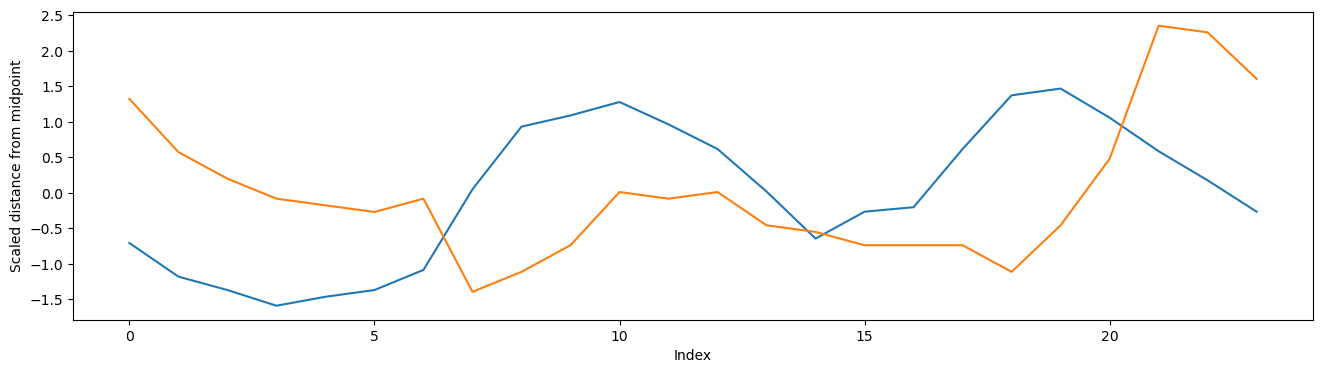

In [6]:
import matplotlib.pyplot as plt

labels, counts = np.unique(y, return_counts=True)

fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
for label in labels:
    ax.plot(X[y==label,0,:][0], label=f'class {label}')
ax.set(ylabel='Scaled distance from midpoint', xlabel='Index')

Here, just the first two time series, one for each label, are shown.

2. Split the data

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

3. Specify the model

In [17]:
from sktime.classification.kernel_based import RocketClassifier

classifier = RocketClassifier()

4. Fit

In [20]:
%%time
classifier.fit(X_train,y_train)

CPU times: total: 6.27 s
Wall time: 4.53 s


RocketClassifier()

Notice that the data passed to the model (`X`) is not cross-sectional data (like in scikit-learn), but panel data: it is a data table having a time index.

5. Predict

In [22]:
y_pred = classifier.predict(X_test)

6. Evaluation

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

0.948905109489051

### Classifiers in sktime

In [26]:
from sktime.registry import all_estimators

all_estimators('classifier', return_names=False)

[sktime.classification.kernel_based._arsenal.Arsenal,
 sktime.classification.dictionary_based._boss.BOSSEnsemble,
 sktime.classification.deep_learning.cnn.CNNClassifier,
 sktime.classification.interval_based._cif.CanonicalIntervalForest,
 sktime.classification.feature_based._catch22_classifier.Catch22Classifier,
 sktime.classification.compose._pipeline.ClassifierPipeline,
 sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier,
 sktime.classification.compose._ensemble.ComposableTimeSeriesForestClassifier,
 sktime.classification.dictionary_based._cboss.ContractableBOSS,
 sktime.classification.interval_based._drcif.DrCIF,
 sktime.classification.dummy._dummy.DummyClassifier,
 sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble,
 sktime.classification.feature_based._fresh_prince.FreshPRINCE,
 sktime.classification.hybrid._hivecote_v1.HIVECOTEV1,
 sktime.classification.hybrid._hivecote_v2.HIVECOTEV2,
 sktime.classification.dictionary_based._boss.Individua

## Is it possible to just use sklearn?
Yes, however cross-sectional algorithms may not be as good as dedicated time series algorithms.
### Comparing algorithms from sklearn with algorithms from sktime

1. Load the data

In [7]:
from sktime.datasets import load_UCR_UEA_dataset
from sktime.datatypes import convert

X,y = load_UCR_UEA_dataset('ItalyPowerDemand', return_X_y=True)
X = convert(X, from_type='nested_univ', to_type='numpy3D')

2. Split the data

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

3. Specify the model

In [9]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

4. Specify a pipeline to convert the data from panel data to cross sectional data

In [17]:
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.reduce import Tabularizer

classifier_pipeline = make_pipeline(
    Tabularizer(),
    classifier
)

The [`Tabularizer`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.panel.reduce.Tabularizer.html) class is a transformer that turns time series/panel data into tabular (i.e., cross sectional) data.

In [11]:
tabularizer_test = Tabularizer()

X_transformed = tabularizer_test.fit_transform(X_train)

In [13]:
type(X_train), type(X_transformed)

(numpy.ndarray, pandas.core.frame.DataFrame)

In [14]:
X_train.shape, X_transformed.shape

((822, 1, 24), (822, 24))

In [20]:
X_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.053806,-0.436429,-1.153847,-1.345159,-1.345159,-1.345159,-1.249503,-1.010364,-0.866880,-0.436429,...,-0.292946,-0.101634,-0.436429,0.472300,1.572341,1.667997,1.572341,1.428857,0.520128,0.137505
1,0.451577,-0.484419,-0.977049,-1.617468,-1.715994,-1.321891,-1.223364,-0.287367,0.697892,1.535363,...,-0.238104,-0.238104,-0.336630,-0.385893,-0.533682,-0.139578,0.155999,1.190522,0.550103,-0.041052
2,-0.769062,-1.039501,-1.377550,-1.647989,-1.512770,-1.512770,-0.904281,-1.107111,-0.295793,0.785964,...,0.447915,0.785964,0.785964,0.447915,0.312695,0.177476,-0.295793,1.326843,0.650745,0.312695
3,-0.411372,-0.673485,-1.110340,-1.241396,-1.416138,-1.328767,-0.848227,-0.586114,-0.804541,0.069169,...,-0.367686,-0.498743,-0.367686,-0.018202,1.772903,2.035016,1.554476,1.423419,0.637080,0.025483
4,-0.818844,-1.274695,-1.350671,-1.603921,-1.603921,-1.578596,-1.148070,-0.742869,0.498060,1.029886,...,0.599360,0.523385,0.548710,0.422085,1.384437,1.409762,0.852611,0.548710,-0.008442,-0.236367


So, passing this transformed table to the estimator, the data points (i.e., the time instants through which the time series develops) are going to be treated as features to train the model on.

5. Fit

In [18]:
classifier_pipeline.fit(X_train,y_train)

Pipeline(steps=[('tabularizer', Tabularizer()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=1))])

6. Predict

In [37]:
y_pred = classifier_pipeline.predict(X_test)

7. Evaluate

In [38]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

0.9781021897810219

## Advanced model building and composition
- Pipelining
- Ensembling
- Tuning
- Reduction

### Pipelining

1. Load the data

In [3]:
from sktime.datasets import load_UCR_UEA_dataset
from sktime.datatypes import convert

X,y = load_UCR_UEA_dataset('ItalyPowerDemand', return_X_y=True)
X = convert(X, from_type='nested_univ', to_type='numpy3D')

2. Split the data

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

3. Specify the model

In [5]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()

4. Specify a pipeline containing a transformer to extract relevant features from the data

In [6]:
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

classifier_pipeline = make_pipeline(
    TSFreshFeatureExtractor(disable_progressbar=True, show_warnings=False),
    classifier
)

[`tsfresh`](https://tsfresh.readthedocs.io/en/latest/index.html) is a library to extract useful features from time series data

5. Fit

In [12]:
# classifier_pipeline.fit(X_train,y_train)
# NOT WORKING: TypeError: acf() got an unexpected keyword argument 'unbiased'. There is a dependency problem between statsmodels and tsfresh

6. Predict

In [ ]:
# y_pred = classifier_pipeline.predict(X_test)

7. Evaluate

In [ ]:
# from sklearn.metrics import accuracy_score

# accuracy_score(y_test,y_pred)

## Time series regression
In time series regression problems the target variable `y` does not consist in to discreet classes, rather in to continous values.

### Basic workflow

1. Load the data

In [147]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/sktime/sktime-tutorial-pydata-global-2021/main/data/benzene_concentration_sample.csv')

y = data['target']
X = data.drop('target',axis=1)

In [89]:
X.shape, y.shape

((300, 240), (300,))

In [45]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,39.550000,43.425000,50.525001,53.349999,59.125001,64.624999,64.125,63.900002,63.924998,67.525000,...,53.700000,42.099999,38.350000,36.700000,29.550,28.150000,26.125000,26.775000,24.175000,28.500000
1,45.775001,46.650000,47.824999,46.866666,51.200000,50.700001,56.750,44.050000,37.599999,33.150001,...,76.400000,47.650001,37.099999,48.650001,71.275,73.975000,71.774998,75.224998,75.950001,74.999998
2,28.250000,31.375000,35.000000,40.225000,43.199999,46.799999,46.475,46.650000,47.950001,45.775001,...,58.625001,58.175000,52.025000,61.400001,53.100,44.325000,40.275000,42.249999,51.775000,76.400000
3,68.175001,72.299999,66.800001,83.224998,78.975000,74.624998,75.125,69.650002,64.425000,52.950001,...,27.125000,28.575000,36.800000,47.475000,50.375,51.300000,53.800000,56.475000,59.200000,62.400001
4,27.100000,26.233333,30.800000,36.825000,40.974999,43.274999,45.550,48.025000,51.125000,50.825000,...,61.475000,56.950000,53.974999,63.875000,65.250,62.500002,58.750000,56.675000,57.424999,55.224999


In [46]:
y.head()

0    12.352617
1     4.765319
2     7.528240
3     5.364484
4    13.704735
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='Count'>

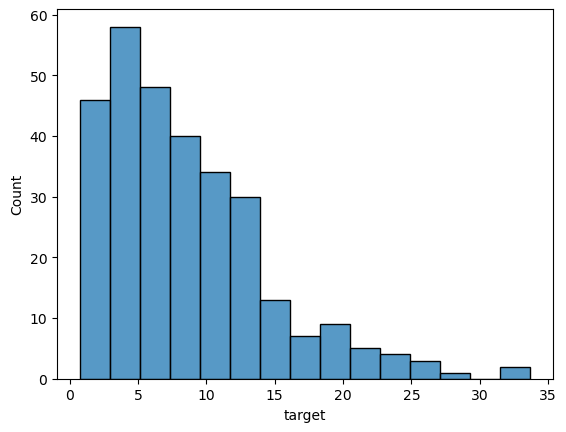

In [49]:
import seaborn as sns

sns.histplot(y)

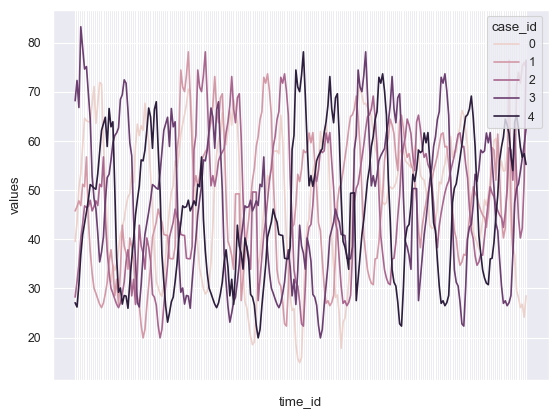

In [83]:
X_to_plot = X.head().stack()

X_to_plot.name = 'values'

X_to_plot.index.names = ['case_id','time_id']

X_to_plot = X_to_plot.reset_index()

sns.set_theme()
with sns.plotting_context('paper'):
    X_plot = sns.lineplot(data=X_to_plot, x='time_id', y='values', hue='case_id')
    X_plot.set(xticklabels=[])

In [156]:
import numpy as np

y_array = y.to_numpy()
X_array = X.to_numpy()
X_array = np.expand_dims(X_array, axis=1)

X_array.shape, y_array.shape

((300, 1, 240), (300,))

2. Split the data

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_array,y_array,shuffle=False)

3. Specify the model

In [152]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_jobs=-1)

4. Define the pipeline

In [153]:
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket

regressor_pipeline = make_pipeline(
    Rocket(n_jobs=-1),
    regressor
)

The [`Rocket`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.panel.rocket.Rocket.html) class applies the random convolutional kernel transform.

5. Fit

In [155]:
regressor_pipeline.fit(X_train,y_train)

Pipeline(steps=[('rocket', Rocket()),
                ('randomforestregressor', RandomForestRegressor())])

6. Predict

In [157]:
y_pred = regressor_pipeline.predict(X_test)

7. Evaluate

In [158]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,y_pred)

25.437496964525614

## Reducing forecasts to time series regression

1. Load the data

In [1]:
from sktime.datasets import load_airline

y = load_airline()

2. Specify the forecasting horizon

In [2]:
import numpy as np

fh = np.arange(12) + 1

3. Split the data

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, fh=fh)

4. Define the model

In [7]:
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction

regressor = make_pipeline(
    Rocket(n_jobs=-1),
    RandomForestRegressor(n_jobs=-1)
)

forecaster = make_reduction(
    regressor,
    scitype='time-series-regressor',
    window_length=12
)

5. Define a pipeline 

In [8]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Detrender

forecaster_pipeline = TransformedTargetForecaster([
    ('detrend', Detrender()),
    ('forecast', forecaster)
])

6. Fit

In [9]:
forecaster_pipeline.fit(y_train)

TransformedTargetForecaster(steps=[('detrend', Detrender()),
                                   ('forecast',
                                    RecursiveTimeSeriesRegressionForecaster(estimator=Pipeline(steps=[('rocket',
                                                                                                       Rocket(n_jobs=-1)),
                                                                                                      ('randomforestregressor',
                                                                                                       RandomForestRegressor(n_jobs=-1))]),
                                                                            window_length=12))])

7. Predict

In [11]:
y_pred = forecaster_pipeline.predict(fh=fh)

8. Evaluate

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

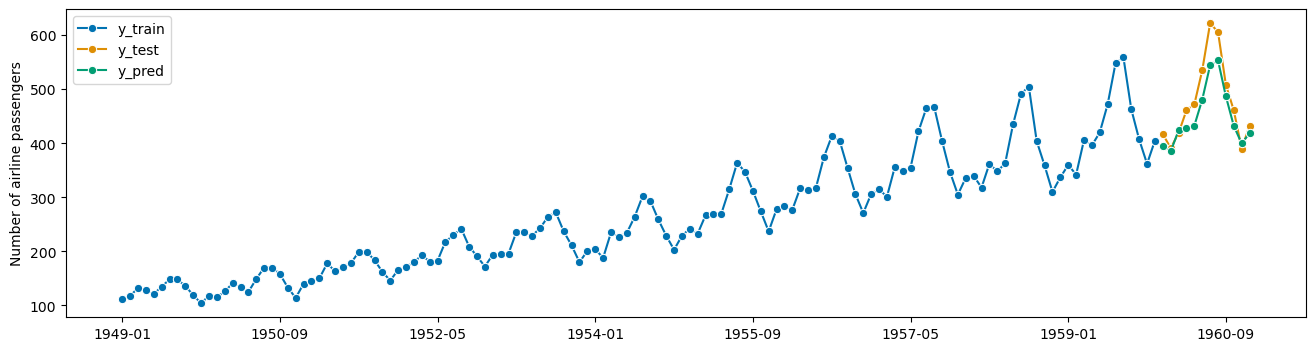

In [12]:
from sktime.utils.plotting import plot_series

plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])

## Multivariate time series classification

### Example

1. Load the data

In [4]:
from sktime.datasets import load_UCR_UEA_dataset
from sktime.datatypes import convert

X, y = load_UCR_UEA_dataset("BasicMotions", return_X_y=True)
X = convert(X, from_type="nested_univ", to_type="numpy3D")

The dataset used in this example was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope. It consists of four classes, which are 
- walking
- resting
- running 
- badminton

Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.

In [16]:
X.shape, y.shape

((80, 6, 100), (80,))

In [2]:
import numpy as np

np.unique(y_train)

array(['badminton', 'running', 'standing', 'walking'], dtype='<U9')

2. Split the data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 6, 100) (60,) (20, 6, 100) (20,)


sktime offers three main ways of solving multivariate time series classification problems:

- **Concatenation** of time series columns into a single long single time series column via `ColumnConcatenator` and apply a classifier to the concatenated data,
- **Column-wise ensembling** via `ColumnEnsembleClassifier` in which one classifier is fitted for each time series column and their predictions aggregated,
- **Bespoke estimator-specific methods** for handling multivariate time series data, e.g. finding shapelets in multidimensional spaces (still work in progress).

#### Time series concatenation
Concatenate multivariate time series/panel data into long univiariate time series/panel and then apply a classifier to the univariate data.

3. Define a pipeline where 
    - Columns are concatenated
    - The estimator is specified

In [6]:
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.pipeline import Pipeline

classifier_pipeline = Pipeline([
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100, n_jobs=-1)),
])

4. Fit

In [7]:
classifier_pipeline.fit(X_train,y_train)

Pipeline(steps=[('concatenate', ColumnConcatenator()),
                ('classify',
                 TimeSeriesForestClassifier(n_estimators=100, n_jobs=-1))])

5. Predict

In [8]:
y_pred = classifier_pipeline.predict(X_test)

6. Evaluate

In [11]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

print(classifier_pipeline.score(X_test, y_test))

1.0
1.0


#### Column ensembling
Fit one classifier for each time series column and then aggregate their predictions. The interface is similar to `ColumnTransformer` from sklearn.

3. Define the `ColumnEnsembleClassifier`, specifying
    - a name for each estimator
    - which estimators to use
    - on which columns use the estimators

In [17]:
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.dictionary_based import BOSSEnsemble

classifier = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=10), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)

4. Fit

In [18]:
classifier.fit(X_train, y_train)

ColumnEnsembleClassifier(estimators=[('TSF0',
                                      TimeSeriesForestClassifier(n_estimators=10),
                                      [0]),
                                     ('BOSSEnsemble3',
                                      BOSSEnsemble(max_ensemble_size=5), [3])])

5. Evaluate

In [19]:
classifier.score(X_test, y_test)

1.0

#### Bespoke classification algorithms
Use bespoke (or classifier-specific) methods for multivariate time series data. In the example try out the [HIVE-COTE](https://link.springer.com/article/10.1007/s10994-021-06057-9) (version 2) algorithm in multidimensional space.

In [20]:
%%time
from sktime.classification.hybrid import HIVECOTEV2

X_train, y_train = load_UCR_UEA_dataset("BasicMotions", split="train", return_X_y=True)
X_test, y_test = load_UCR_UEA_dataset("BasicMotions", split="test", return_X_y=True)

classifier = HIVECOTEV2(
    stc_params={"n_shapelet_samples": 1000},
    drcif_params={"n_estimators": 25},
    arsenal_params={"n_estimators": 10},
    tde_params={"n_parameter_samples": 100},
    verbose=0,
)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: total: 7min 4s
Wall time: 6min 39s


1.0

HIVE-COTE is, as of today, the best algorithm for time series classification